# Bunch of examples of how you can automate selecting collective variables from dynamics trajectories

In [1]:
%matplotlib inline

Load a trajectory of a hydrogen abstraction involving hexane and cyanide. H3 is taken off C4 by C0 as illustrated below:

<video controls src="media/hexane.mp4" />

In [23]:
import glob
from qml.qmlearn.data import Data
import numpy as np

filenames = sorted(glob.glob('data/hexane/hex_*.xyz'))
# Use a QML data object, that stores nuclear_charges as well as coordinates
# (data.nuclear_charges, data.coordinates)
# The reaction happens around frame 7570 or so, so only load a window around the abstraction
# A larger set to train on
large_data = Data(filenames[6500:8650])
# A smaller set to visualize
small_data = Data(filenames[7410:7640])

Since this is a simple reaction, the natural choice of collective variables are the interatomic distances between atoms 0-3 and 0-4.

In [3]:
# Calculate the euclidian distances between the abstracted hydrogen
# and the two relevant carbons.
d1 = np.sum((small_data.coordinates[:,3] - small_data.coordinates[:,4])**2, axis=1)**0.5
d2 = np.sum((small_data.coordinates[:,3] - small_data.coordinates[:,0])**2, axis=1)**0.5

 Visualize the data. Top plot shows one reaction coordinate versus another,
 with the colour indicated evolution over time, going from purple to yellow.
 The bottom plots shows how each reaction coordnate evolves over time, with
 blue being collective variable 1 and orange being variable 2.

/home/lb17101/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/lb17101/opt/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


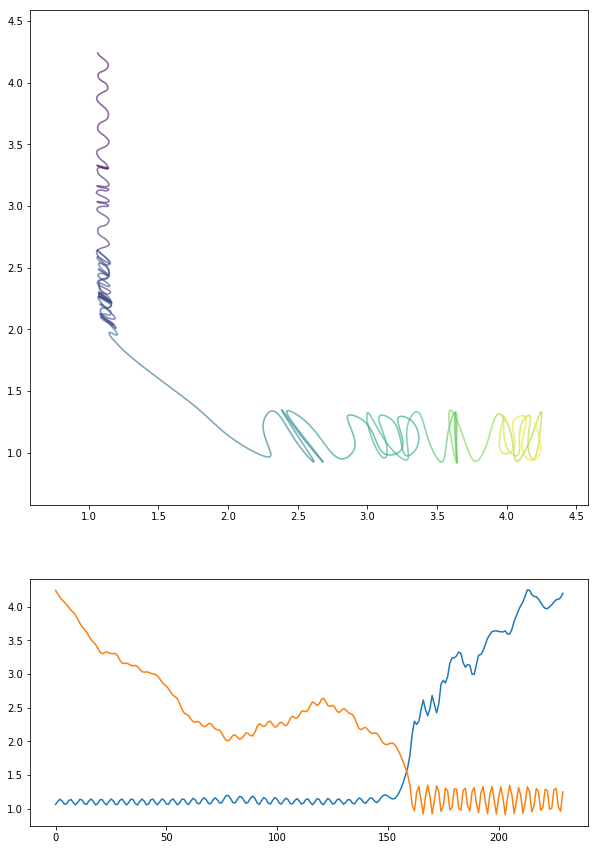

In [4]:
import ddr

# The plot can be saved to img.png by using ddr.colorplot(d1,d2, 'img') instead.
ddr.colorplot(d1,d2)

These variables are good since you have to minimize one and maximize another to make the reaction occur and the reactant/products doesn't overlap. The only slight problem is the vibrations.

 If it isn't clear which features make the best collective variables
 we can create some sort of high dimensional representations for the system,
 and then apply some dimensionality reduction algorithm.
 For example the upper triangle of the interatomic distance matrix, followed
 by PCA.

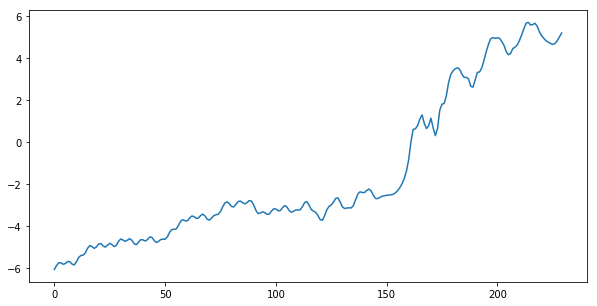

In [5]:
from sklearn.decomposition import PCA

# Get the interatomic distances for all molecules
large_rep = ddr.Distances().fit_transform(large_data)
small_rep = ddr.Distances().fit_transform(small_data)
# Fit PCA with 1 component
model = PCA(n_components=1).fit(large_rep)
# Get the collective variables found by PCA
var = model.transform(small_rep)
# Visualize
ddr.colorplot(var)

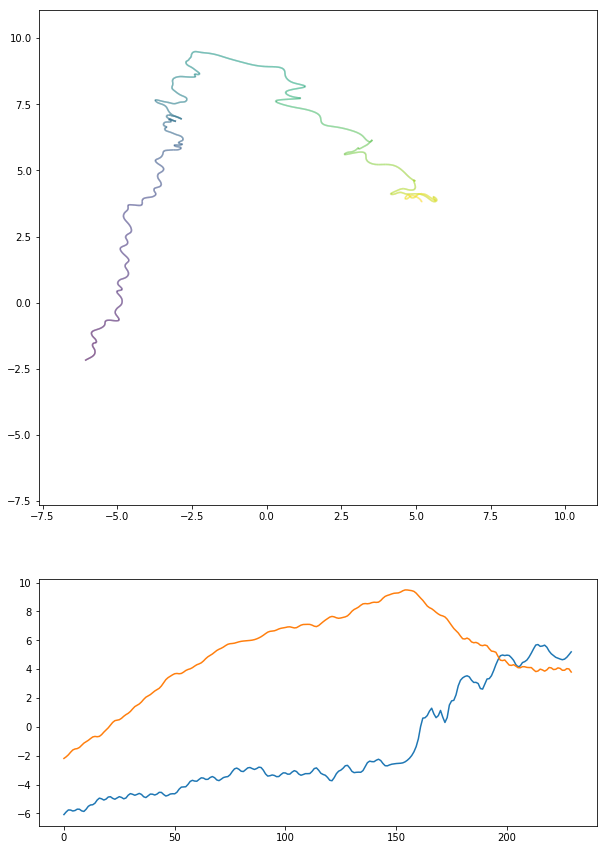

In [25]:
# Do PCA with 2 components
model = PCA(n_components=2).fit(large_rep)
var = model.transform(small_rep)
# Visualize
ddr.colorplot(var[:,0], var[:,1])

The first collective variable increases steadily over the duration of the reaction, which means that the distance matrix with PCA describes the reaction reasonably well. The second variable helps spread out the space a bit and would assist in enhanced sampling.

Instead of first generating a representation and then reducing dimensions we can construct a pipeline model that does all of it in one go:

In [7]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(ddr.Distances(), PCA(n_components=2))
# We can fit on one set of data
model.fit(large_data)
# And transform the same or another set (or use fit_transform to both fit and transform)
var = model.transform(small_data)

 We can do the dimensionality reduction with many other algorithms. Any of the methods
 from [sklearn.decomposition](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition)
 or from [sklearn.manifold](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold)
 should work fine. None of them treats the data as a time-series. But tICA does:

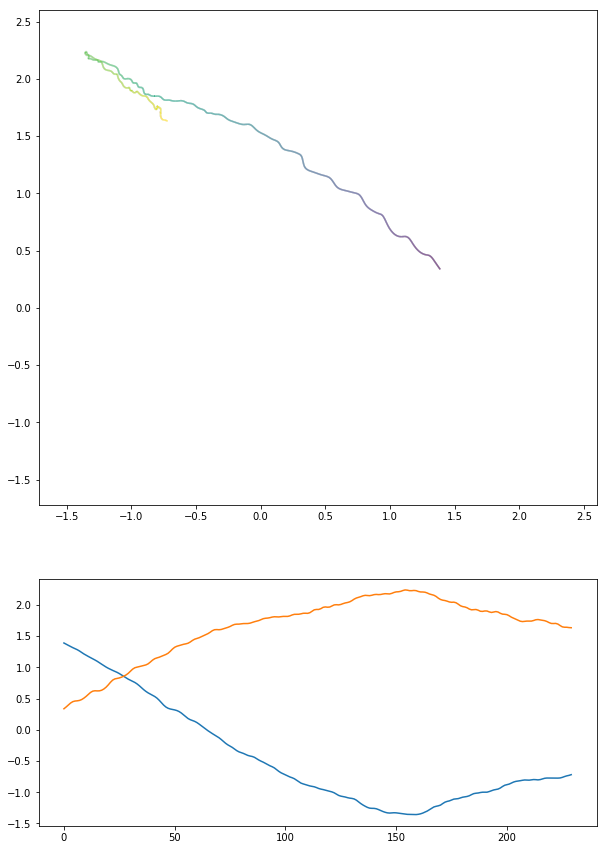

In [8]:
model = make_pipeline(ddr.Distances(), ddr.tICA(n_components=2)).fit(large_data)
var = model.transform(small_data)
ddr.colorplot(var[:,0], var[:,1])

This is pretty rubbish. If we only do tICA on the smaller dataset localized around the reaction, things look similar to PCA.

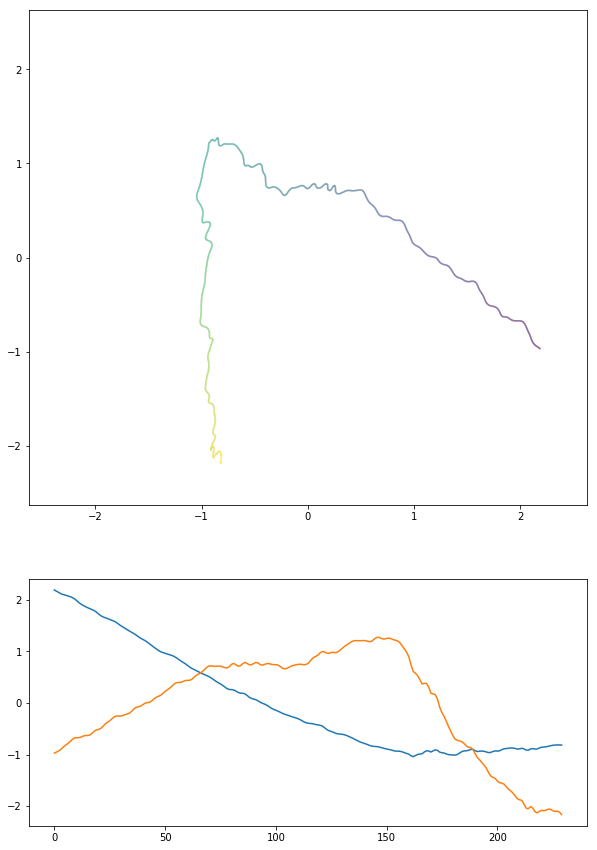

In [9]:
model = make_pipeline(ddr.Distances(), ddr.tICA(n_components=2)).fit(small_data)
var = model.transform(small_data)
ddr.colorplot(var[:,0], var[:,1])

 Some dimensionality reduction techniques such as TSNE works differently than PCA
 in the sense that you can't transform data that wasn't used to create the manifold.
 One way around this is to fit a regression model to the manifold and use that to do
 the transform

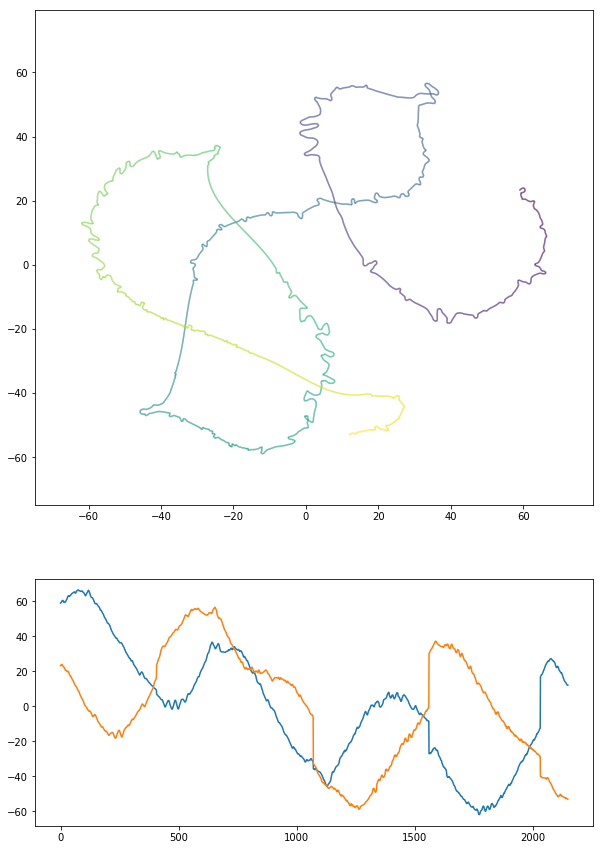

In [10]:
from sklearn.manifold import TSNE

# First get the collective variables
var = make_pipeline(ddr.Distances(), TSNE(n_components=2)).fit_transform(large_data)
ddr.colorplot(var[:,0], var[:,1])

Although the region around the reaction (frame ~1050) is well described by the first collective variable, everything else is a bit inconsistent. Training a regression model on 2000 data points are a bit memory heavy, so we'll continue with the smaller subset.

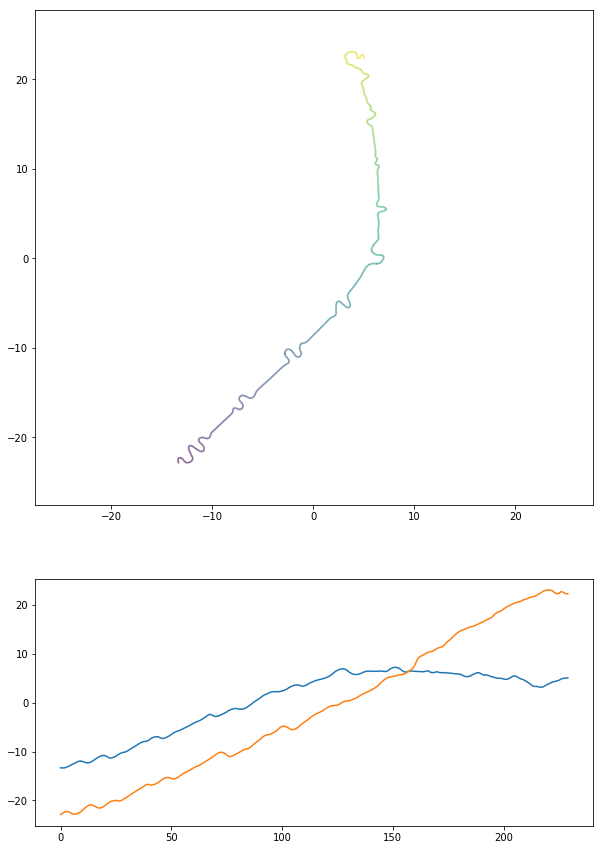

In [11]:
# First get the collective variables
org_var = make_pipeline(ddr.Distances(), TSNE(n_components=2)).fit_transform(small_data)
ddr.colorplot(org_var[:,0], org_var[:,1])

We'll fit a Kernel Ridge Regression model to the fitted collective variables using cross validation.

In [12]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV, KFold

# Create the Kernel Ridge Regression pipeline.
basemodel = make_pipeline(ddr.Distances(), KernelRidge())
# The optimal parameters can be cross validated by doing a grid search
params = {'kernelridge__alpha': 10.**np.arange(-8,-3, 0.5),
          'kernelridge__kernel': ['linear', 'rbf', 'laplacian', 'polynomial'],
          'kernelridge__gamma': 10.**np.arange(-9,-3, 0.5),
          }
model = GridSearchCV(basemodel, param_grid=params,
        cv=KFold(n_splits=5, shuffle=True),
            scoring='neg_mean_squared_error')

model.fit(small_data, org_var)
# Print the best parameters found by cross validation
print(model.best_params_)

{'kernelridge__alpha': 1e-08, 'kernelridge__gamma': 0.00031622776601683794, 'kernelridge__kernel': 'rbf'}


The now trained model can be used to run predictions on the large data

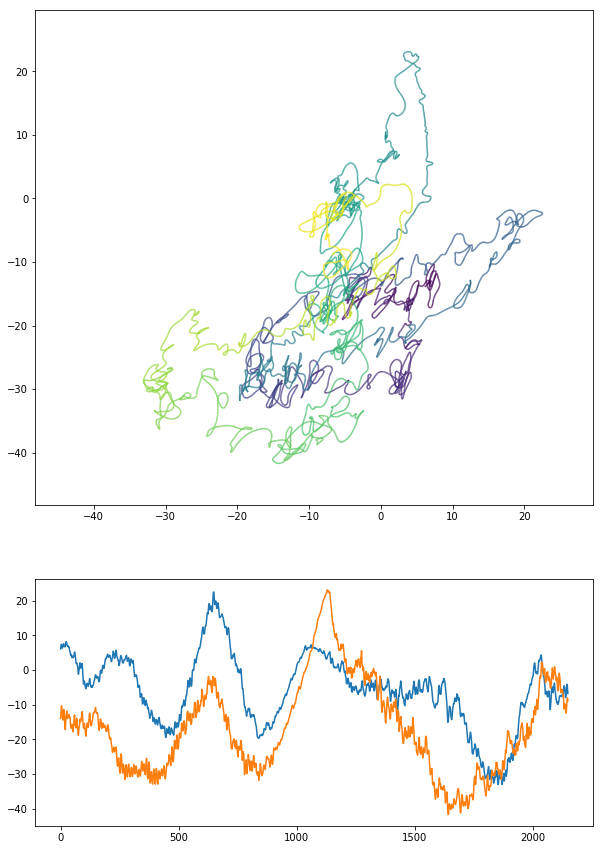

In [13]:
var = model.predict(large_data)
ddr.colorplot(var[:,0], var[:,1])

The reaction region has overlap with reactant/product region, compared to the collective variable found with TSNE on the large subset. This shows that the TSNE model captures the wrong things when only trained on the small subset.

 It can be hard to figure out which atoms are involved in the reaction coordinates
 found by dimensionality reduction. One way of doing this is to take a structure
 Do a bunch of small displacements to its coordinates and see how the reduced space
 changes. The ddr.significance function takes one or more indices of snapshots in the
 data object, creates minor displacements and calculates the partial derivatives of the
 reduced space with respect to atomic coordinates. It then calculates the norm for each atom
 and calculates the percentage of the total norm that each atom contributes with.


In [14]:
# Fit some collective variables
model = make_pipeline(ddr.Distances(), PCA(n_components=2)).fit(large_data)
var = model.transform(small_data)

In [15]:
# Try to get the significance for two different structures,
# a reactant structure (H on hexane) and a product structure (H on cyanide)
s = ddr.significance(small_data, [0,200], model)
print((s[0,0]))
print((s[0,1]))
print((s[1,0]))
print((s[1,1]))

[0.08179969 0.10104974 0.01976775 0.39944707 0.03314347 0.01733134
 0.03137466 0.01793901 0.02936806 0.02475059 0.00875523 0.03127289
 0.02451524 0.03707008 0.02699592 0.00821777 0.02970515 0.02796323
 0.01441762 0.03511549]
[0.21239059 0.22624672 0.00604391 0.05590009 0.02089009 0.02968002
 0.01751993 0.0449778  0.03239774 0.03806983 0.02994711 0.02116453
 0.01164293 0.00785455 0.0706012  0.03224512 0.02731361 0.04125288
 0.03504777 0.03881358]
[0.05153491 0.08116467 0.01530205 0.45001291 0.03185552 0.01745788
 0.03125541 0.01919444 0.02798443 0.02438587 0.01419323 0.03092483
 0.02761409 0.03953775 0.02891845 0.00586997 0.02957495 0.02425972
 0.01430809 0.03465083]
[0.19003074 0.20622557 0.00807432 0.09251872 0.02282555 0.02908219
 0.01884228 0.04471387 0.03309952 0.03702025 0.02959771 0.02146981
 0.01445387 0.0074854  0.06622201 0.03610336 0.02770565 0.04280988
 0.03528291 0.0364364 ]


In [16]:
# We can get e.g. all atoms that contribute more than 10% to a reaction coordinate by
s_sorted = np.sort(s[0,0])[::-1]
s_args = np.argsort(s[0,0])[::-1]
significant_indices = s_args[s_sorted > 0.1]
print(significant_indices)
s_sorted = np.sort(s[0,1])[::-1]
s_args = np.argsort(s[0,1])[::-1]
significant_indices = s_args[s_sorted > 0.1]
print(significant_indices)
s_sorted = np.sort(s[1,0])[::-1]
s_args = np.argsort(s[1,0])[::-1]
significant_indices = s_args[s_sorted > 0.1]
print(significant_indices)
s_sorted = np.sort(s[1,1])[::-1]
s_args = np.argsort(s[1,1])[::-1]
significant_indices = s_args[s_sorted > 0.1]
print(significant_indices)

[3 1]
[1 0]
[3]
[1 0]


The important atoms of the first collective variable are the hydrogen (and the nitrogen for the reactant structure). For the second variable the important atoms are both the atoms of cyanide.
Note that two structures can have different significances. If we defined significance to be per feature (in this case interatomic distances) instead of per atom, this would match the pca components exactly.
(This might be a reasonable thing to implement, getting which interatomic distances are important)

We could use inverse distances instead of distances as well:

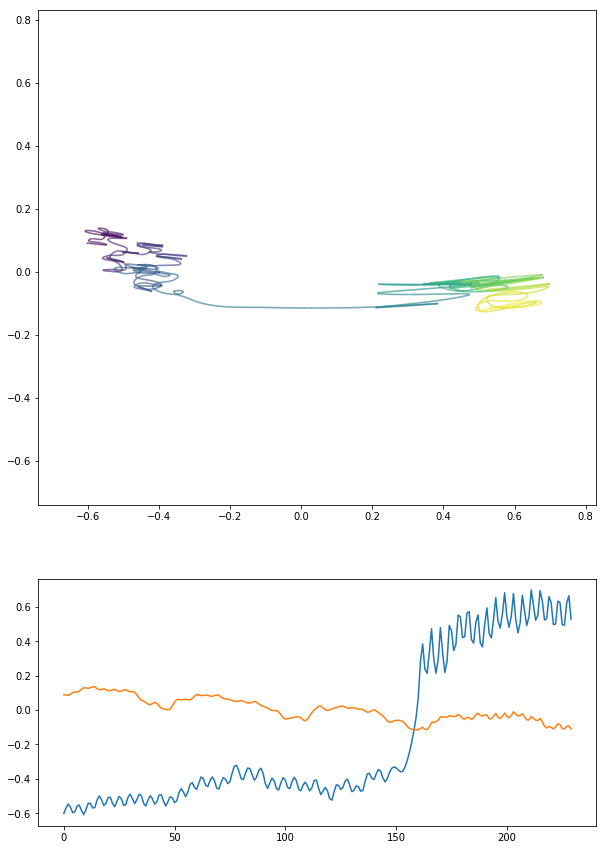

In [36]:
model = make_pipeline(ddr.InverseDistances(), PCA(n_components=2)).fit(large_data)
var = model.transform(small_data)
ddr.colorplot(var[:,0], var[:,1])
# Print out the significant atoms

 As an alternative to simple distances, we can use representations from machine learning.
 We can use global representations that describe the entire molecular system. This makes
 sure that we have permutation invariance such that our collective variables will
 be able to describe abstraction of any H atoms.

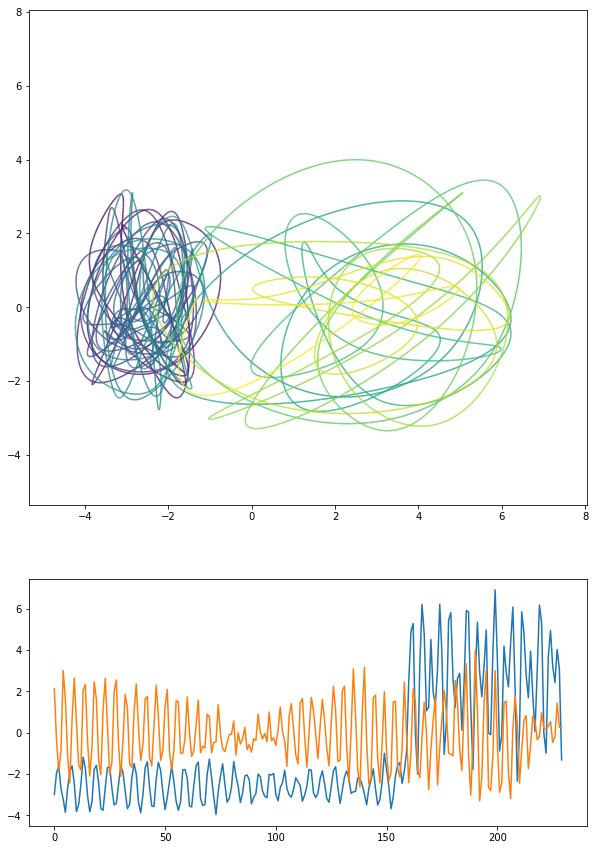

In [38]:
# Use the slatm representation
model = make_pipeline(ddr.GlobalSLATM(), PCA(n_components=2)).fit(large_data)
var = model.transform(small_data)
ddr.colorplot(var[:,0], var[:,1])

This is a complete mess since the representation is very high dimensional. Using tICA is nescesary to capture the underlying structure.

/home/lb17101/opt/anaconda3/lib/python3.6/site-packages/msmbuilder/decomposition/tica.py:405: UserWarning: The number of features (2150) is greater than the length of the data (2609). The covariance matrix is not guaranteed to be positive definite.
  warnings.warn("The number of features (%d) is greater than the length of the data (%d). The covariance matrix is not guaranteed to be positive definite." % (X.shape[0], X.shape[1]))


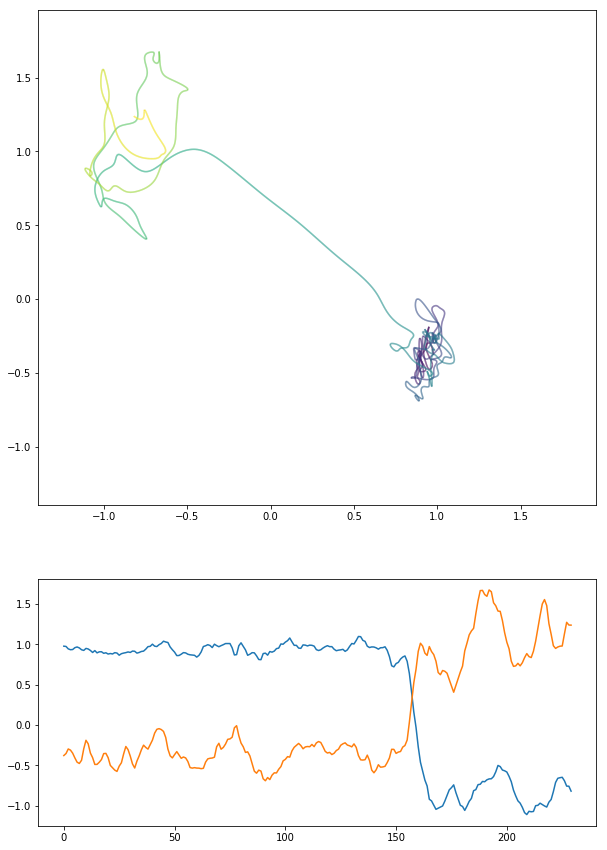

In [44]:
# Use the slatm representation
model = make_pipeline(ddr.GlobalSLATM(), ddr.tICA(n_components=2)).fit(large_data)
var = model.transform(small_data)
ddr.colorplot(var[:,0], var[:,1])

We could also use an atomic representation concatenated together, but this makes us lose permutation invariance

/home/lb17101/opt/anaconda3/lib/python3.6/site-packages/msmbuilder/decomposition/tica.py:405: UserWarning: The number of features (2150) is greater than the length of the data (5360). The covariance matrix is not guaranteed to be positive definite.
  warnings.warn("The number of features (%d) is greater than the length of the data (%d). The covariance matrix is not guaranteed to be positive definite." % (X.shape[0], X.shape[1]))


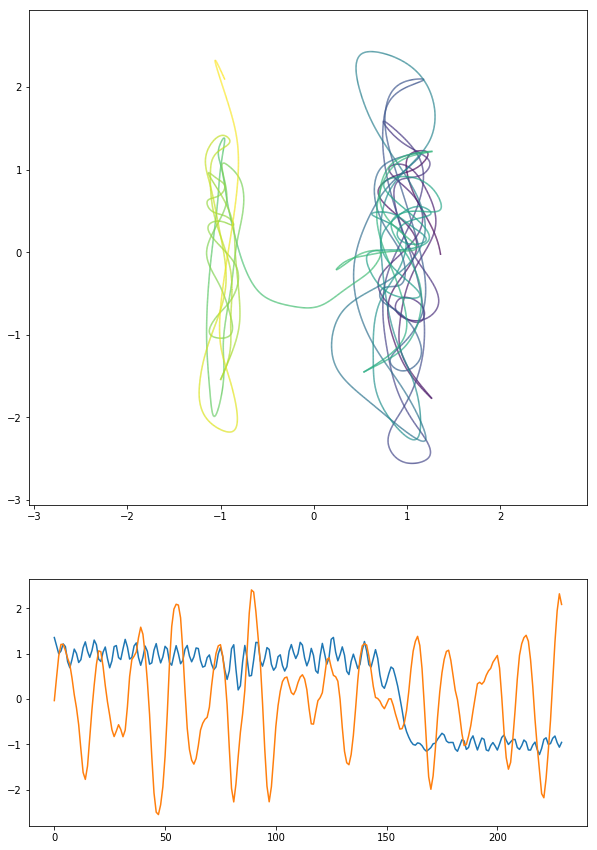

In [41]:
# Change parameters since we would run into memory issues otherwise
dgrid = 0.3
sigma = 0.05/0.03 * dgrid
model = make_pipeline(ddr.AtomicSLATM(dgrid2=dgrid, dgrid3=dgrid, sigma2=sigma, sigma3=sigma), ddr.tICA(n_components=2))
model.fit(large_data)
var = model.transform(small_data)
ddr.colorplot(var[:,0], var[:,1])

Or we could just use the atomic representation of the cyanide carbon, which would make the representation permutation invariant again.

/home/lb17101/opt/anaconda3/lib/python3.6/site-packages/msmbuilder/decomposition/tica.py:405: UserWarning: The number of features (2150) is greater than the length of the data (2609). The covariance matrix is not guaranteed to be positive definite.
  warnings.warn("The number of features (%d) is greater than the length of the data (%d). The covariance matrix is not guaranteed to be positive definite." % (X.shape[0], X.shape[1]))


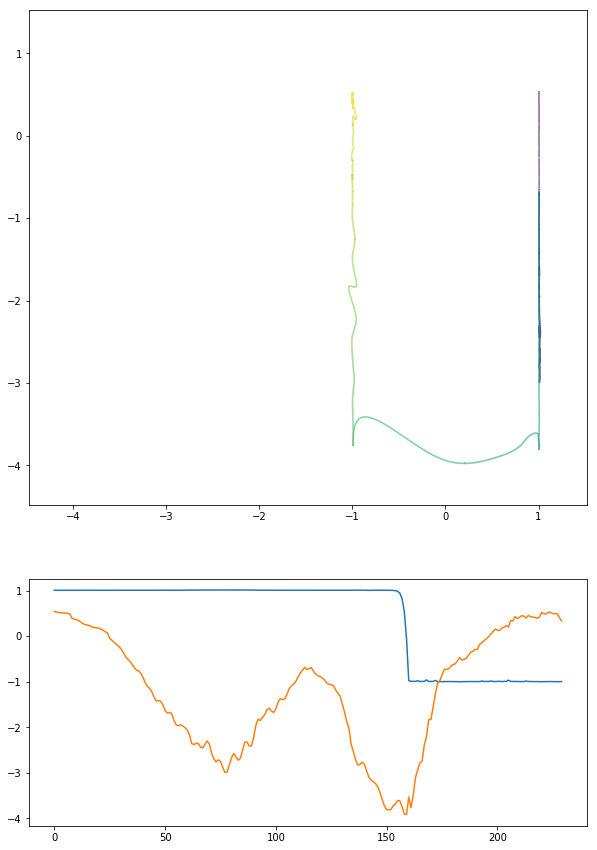

In [49]:
model = make_pipeline(ddr.AtomicSLATM(indices=[0]), ddr.tICA(n_components=2)).fit(large_data)
var = model.transform(small_data)
ddr.colorplot(var[:,0], var[:,1])

 An alternative approach is to use a subset of the molecules as basis and then
 calculate the distance (using some metric) between them and all other molecules.

 One way of doing this would be to align every molecule to the basis molecules,
 and calculate the rmsd displacement:

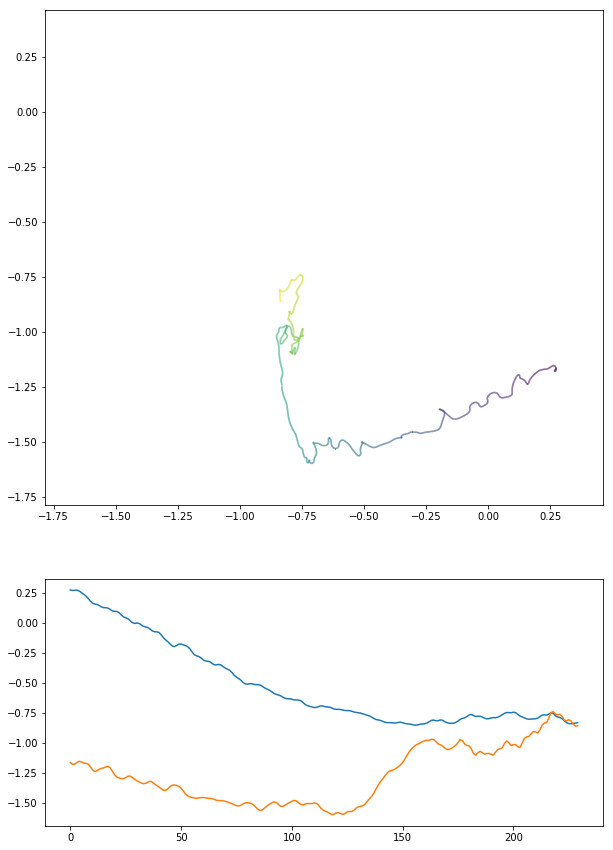

In [50]:
# Use the molecules near the transition as basis
indices = np.arange(140, 180) # This is indices of the basis in the data object
model = make_pipeline(ddr.Align(indices), ddr.tICA(n_components=2)).fit(large_data)
var = model.transform(small_data)
ddr.colorplot(var[:,0], var[:,1])

Alternatively we can use the same machine learning representations as before
and calculate the manhattan distance to the basis representations

(230, 40)


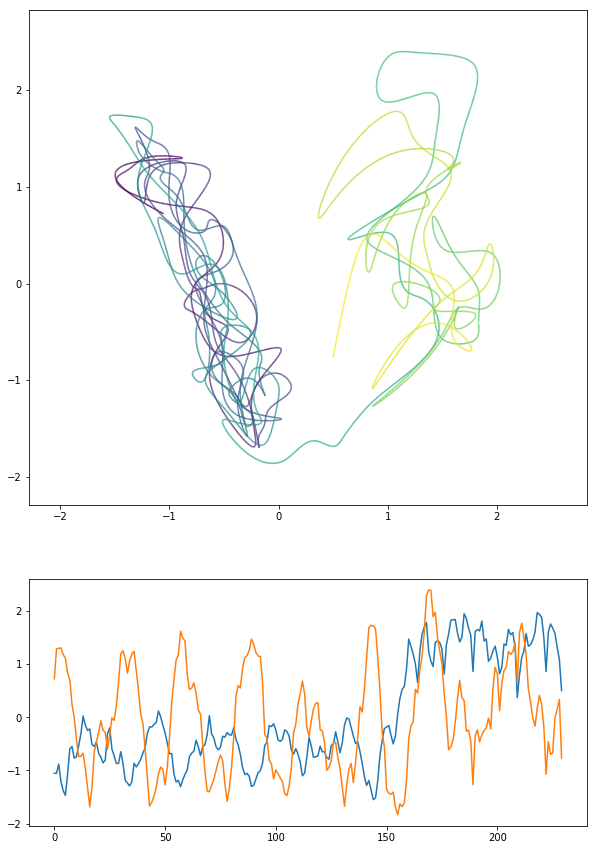

In [52]:
from qml.ml.kernels.distance import manhattan_distance#, l2_distance

indices = np.arange(140,180)
reps = ddr.GlobalSLATM().fit_transform(small_data)
basis_reps = reps[indices]
distance_features = manhattan_distance(reps, basis_reps)
print(distance_features.shape)
var = ddr.tICA(n_components=2).fit_transform(distance_features)
ddr.colorplot(var[:,0], var[:,1])

 And we could transform the distances with Kernels
 (which is how PCA is related to KernelPCA in sklearn, but doesn't exist for tICA)

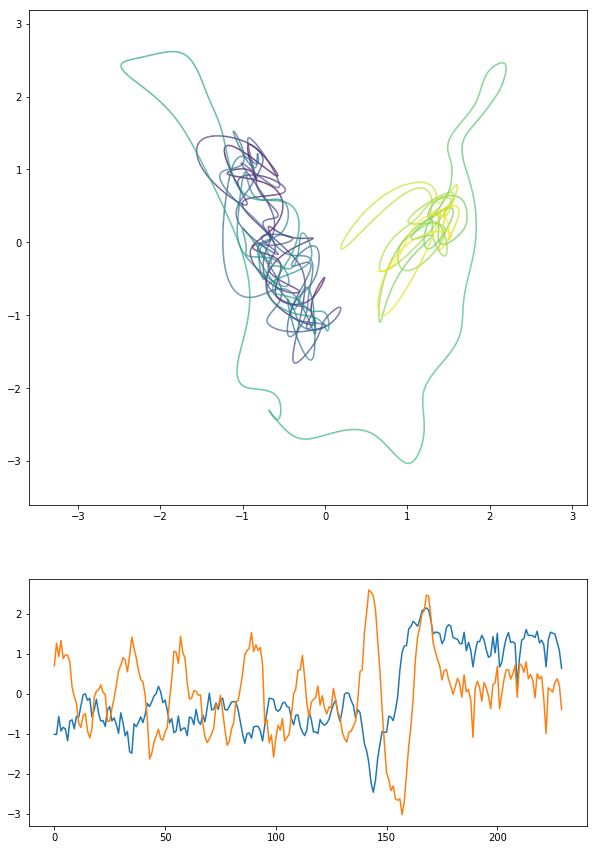

In [62]:
indices = np.arange(140,180)
reps = ddr.GlobalSLATM().fit_transform(small_data)
basis_reps = reps[indices]
distance_features = manhattan_distance(reps, basis_reps)
kernel = np.exp(-distance_features/10.0)
var = ddr.tICA(n_components=2).fit_transform(kernel)
ddr.colorplot(var[:,0], var[:,1])